In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
dataset_dir = '/kaggle/input/kangaroo-detection/'
images_dir = dataset_dir + 'images/'
annotations_dir = dataset_dir + 'annots/'


In [4]:
from xml.etree import ElementTree
 
# function to extract bounding boxes from an annotation file
def extract_boxes(filename):

    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    image_name = root.find('filename').text
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return [boxes, width, height], image_name
 
# extract details form annotation file
data, img = extract_boxes(annotations_dir+'00001.xml')
# summarize extracted details
print(data, img)

[[[233, 89, 386, 262], [134, 105, 341, 253]], 450, 319] 00001.jpg


In [5]:
def process_image(img):
    dim = (224,224)
    img = plt.imread(img)
    img = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
    return img

In [6]:
process_image(images_dir+'00001.jpg').shape

(224, 224, 3)

In [7]:
from os import listdir

dataset_y = []
dataset_X = []
for file in listdir(annotations_dir):
    # file 00090.jpg doesn't exist
    if file=='00090.xml':
        continue
    data, img_name = extract_boxes(annotations_dir+file)
    img = images_dir+img_name
    dataset_y.append(data)
    processed_image = process_image(img)
    dataset_X.append(processed_image)

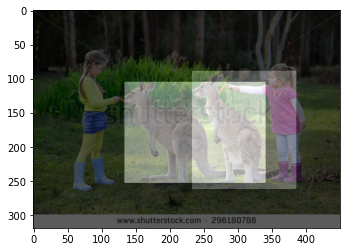

In [8]:
file = '00001.xml'

data, img = extract_boxes(annotations_dir+file)

boxes, w, h = data
# create one array for all masks, each on a different channel
masks = np.zeros([h, w, len(boxes)], dtype='uint8')
# create masks

for i in range(len(boxes)):
    box = boxes[i]
    row_s, row_e = box[1], box[3]
    col_s, col_e = box[0], box[2]
    masks[row_s:row_e, col_s:col_e, i] = 1
    
plt.imshow(plt.imread(images_dir+img))
for i in range(len(boxes)):
    plt.imshow(masks[:, :, i], cmap='gray', alpha=0.4)

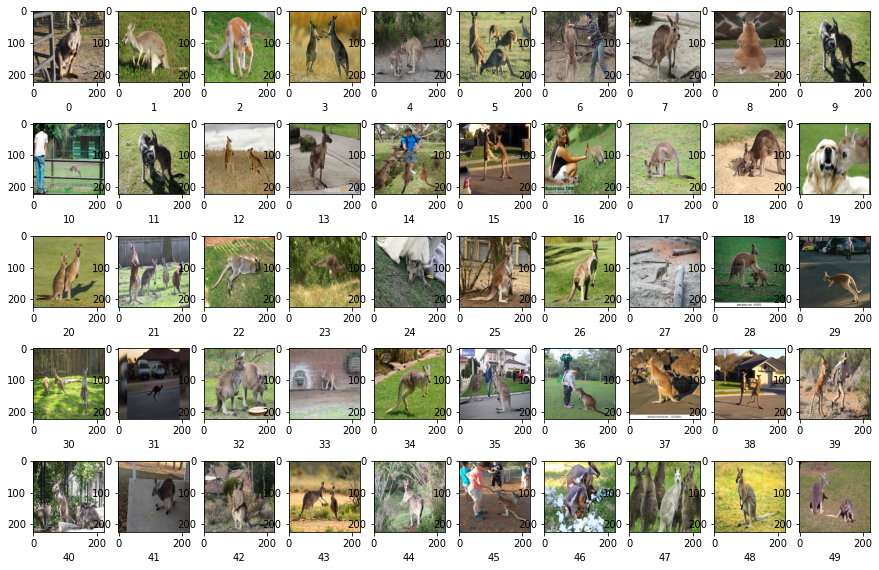

In [9]:
fig, axes = plt.subplots(5,10, figsize=(15,10))
ax = axes.flatten()
for i in range(50):
    ax[i].imshow(dataset_X[i])
    ax[i].set_xlabel(i)

Resizing, drawing and returning masks.

In [10]:
def get_and_draw_masks(data, draw=None):
    boxes, w, h = data
    masks = np.zeros([h, w, len(boxes)], dtype='uint8')
    for i in range(len(boxes)):
        box = boxes[i]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
    if draw:
        for i in range(len(boxes)):
            mask = cv2.resize(masks[:, :, i], (224,224))
            plt.imshow(mask[:, :], cmap='gray', alpha=0.4)
    return mask

In [11]:
# draw mask given xmin,ymin, xmax,ymax

def draw_mask(box):
    masks = np.zeros([224, 224], dtype='uint8')
    row_s, row_e = box[1], box[3]
    col_s, col_e = box[0], box[2]
    masks[row_s:row_e, col_s:col_e] = 1
    plt.imshow(masks[:, :], cmap='gray', alpha=0.4)
    return masks

Getting our dataset ready for training.

In [15]:
y = []
X = []
for i in range(len(dataset_y)):
    if len(dataset_y[i][0]) > 1:
        continue
    
    data, w, h = dataset_y[i]
    data = data[0]

    h_ratio = 224/h
    w_ratio = 224/w

    new_data = [round(w_ratio*data[0]), round(h_ratio*data[1]), round(w_ratio*data[2]), round(h_ratio*data[3])]
    y.append(new_data)
    X.append(dataset_X[i])
    
X = np.array(X)
y = np.array(y)
# X = X/255
X.shape, y.shape

((107, 224, 224, 3), (107, 4))

In [16]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [17]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='relu'))
    
    return model

In [18]:
# model = Sequential()
# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=1024,activation="relu"))
# model.add(Dense(units=4, activation="linear"))


# import keras
# from keras.optimizers import Adam
# # opt = Adam(lr=0.001)
input_shape = (224, 224, 3)
model = createModel()
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['mse'])

In [19]:
# # Part 2 - Fitting the CNN to the images

model.fit(X, y, epochs=500)

Epoch 1/500
4/4 [==============================] - 11s 3s/step - loss: 1377177.2500 - mse: 1377177.2500
Epoch 2/500
2/4 [==============>...............] - ETA: 4s - loss: 19533.4883 - mse: 19533.4883

KeyboardInterrupt: 

In [ ]:
i=5
pred = np.round(model.predict(np.array([X[i]]))[0]).astype(int)
plt.imshow(X[i])
draw_mask(pred)
print(y[i], pred)